In [44]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import scipy
import control
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize

In [45]:
# Inteprolation
# 1D Methods
def upsample_fourier(frequency, signal, target_frequency, time_vector):
    upsampled_signal = []
    
    upsampled_signal = scipy.signal.resample(signal, int(target_frequency/frequency*len(signal)))

    return upsampled_signal

def spline_linear(frequency, signal, target_frequency, time_vector):
    upsampled_signal = []
    new_time = np.arange(start=time_vector[0], stop=time_vector[-1], step=1/target_frequency)

    
    upsampled_signal = np.interp(new_time, time_vector, signal)

    return upsampled_signal

def spline_cubic(frequency, signal, target_frequency, time_vector):
    new_time = np.arange(start=0, stop=time_vector[-1], step=1/target_frequency)
    upsampled_signal = []
    
    f = scipy.interpolate.CubicSpline(time_vector, signal, bc_type='natural')
    upsampled_signal = (f(new_time))

    return upsampled_signal

def interpolation_lanczos(frequency, signal, target_frequency, time_vector, a):

    # print(np.round(a*target_frequency/frequency))

    scaling_factor = np.round(target_frequency/frequency)

    lanczos_kernel = np.ones(int(2*scaling_factor*a-1))
    middle = np.floor(len(lanczos_kernel)/2)

    for i in range(len(lanczos_kernel)):
        # print(((i-middle)/scaling_factor))
        cur_val = (i-middle)/scaling_factor
        lanczos_kernel[i] = np.sinc(cur_val) * np.sinc(cur_val / (a))

    # print(lanczos_kernel)

    new_time = np.linspace(start=0, stop=time_vector[-1], num=int(len(signal)*scaling_factor))
    padded_signal = np.zeros((len(new_time)))
    for i in range(len(time_vector)):
        padded_signal[int(i*scaling_factor)] = signal[i]

    upsampled_signal = []
    
    upsampled_signal = np.convolve(padded_signal, lanczos_kernel, mode='same')

    # plt.stem(new_time, padded_signal[0])
    # plt.plot(new_time, upsampled_signal[0], color='red')
    # plt.xlim([14, 15])

    return upsampled_signal

def interpolation_bspline(frequency, signal, target_frequency, time_vector, s, k_value):

    new_time = np.arange(start=time_vector[0], stop=time_vector[-1], step=1/target_frequency)
    upsampled_signal = []
    # print(time_vector)

    t, c, k = scipy.interpolate.splrep(time_vector, signal, s=s, k=k_value)
    spline = scipy.interpolate.BSpline(t, c, k, extrapolate=False)
    upsampled_signal = spline(new_time)
    # print(signal[s] == upsampled_signal[-1])

    return upsampled_signal

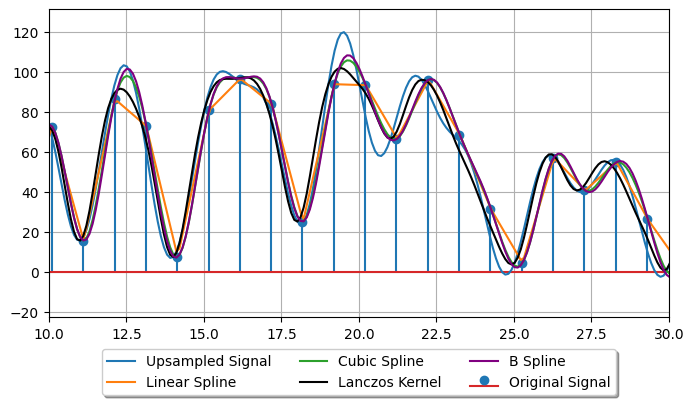

In [46]:
time_signal = np.linspace(0, 100, 100)
original_signal = 100*np.random.rand(100)
upsample_signal = upsample_fourier(frequency=1, signal=original_signal, target_frequency=10, time_vector=time_signal)
linear_signal = spline_linear(frequency=1, signal=original_signal, target_frequency=10, time_vector=time_signal)
cubic_signal = spline_cubic(frequency=1, signal=original_signal, target_frequency=10, time_vector=time_signal)
lanczos_signal = interpolation_lanczos(frequency=1, signal=original_signal, target_frequency=10, time_vector=time_signal, a=2)
bspline_signal = interpolation_bspline(frequency=1, signal=original_signal, target_frequency=10,  time_vector=time_signal, s=0, k_value=4)

new_time = np.linspace(0, 100, 1000)
plt.figure(figsize=[8,4])
plt.stem(time_signal, original_signal, label='Original Signal')
plt.plot(new_time, upsample_signal, label='Upsampled Signal')
plt.plot(new_time, linear_signal, label='Linear Spline')
plt.plot(new_time, cubic_signal, label='Cubic Spline')
plt.plot(new_time, lanczos_signal, label='Lanczos Kernel', color='black')
plt.plot(new_time, bspline_signal, label='B Spline', color='purple')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=True, ncol=3)
plt.xlim([10, 30])
plt.grid()

In [47]:
def process_gait_type(calibration_paths, data_paths, data_dictionary_labels, window_sizes_dictionary, plot_individual_trials, smoothing, unique_dictionary_labels, knee_height, save_label, offset_variance=0):

    knee_windows_all = {}
    ankle_windows_all = {}
    ankle_inversion_windows_all = {}

    knee_windows_all_original = {}
    ankle_windows_all_original = {}
    ankle_inversion_windows_all_original = {}
    
    frequency = {}

    for index, data_path in enumerate(data_paths):

        print(f"Label: {data_dictionary_labels[index]} and Index: {index}")

        timeVector, euler_knee, euler_ankle, euler_femur_tibia, euler_tibia_foot = get_angles(calibration_paths[index], data_path, left_leg=True, low_pass=False, cadence=1/5)
 
        angle_knee_flexion_unfiltered = np.array([e[1] for e in euler_knee])
        angle_ankle_flexion_unfiltered = np.array([e[1] for e in euler_ankle])
        angle_ankle_inversion_unfiltered = np.array([e[2] for e in euler_ankle])

        angle_knee_flexion = butterworth_lowpass(data=angle_knee_flexion_unfiltered, cutoff=10, fs=30, order=2)
        angle_ankle_flexion = butterworth_lowpass(data=angle_ankle_flexion_unfiltered, cutoff=5, fs=30, order=2)
        angle_ankle_inversion = butterworth_lowpass(data=angle_ankle_inversion_unfiltered, cutoff=5, fs=30, order=2)
        
        window_before_peak = window_sizes_dictionary[data_dictionary_labels[index]][0]
        window_after_peak = window_sizes_dictionary[data_dictionary_labels[index]][1]
        knee_params = [np.round((window_before_peak + window_after_peak)*0.7), knee_height, False]

        knee_windows, ankle_windows, ankle_inversion_windows, knee_peaks = get_cropped_windows(angle_knee_flexion, angle_ankle_flexion, 
                                                                                               angle_ankle_inversion, window_before_peak, 
                                                                                               window_after_peak, knee_params, offset_variance)

        frequency[data_dictionary_labels[index]] = 30

        knee_windows_original = knee_windows
        ankle_windows_original = ankle_windows
        ankle_inversion_windows_original = ankle_inversion_windows

        if (smoothing != 0):
            knee_windows_smoothed = []
            ankle_windows_smoothed = []
            ankle_inversion_windows_smoothed = []
            for index_smooth in range(len(knee_windows)):
                frequency[data_dictionary_labels[index]] = smoothing/len(knee_windows[index_smooth]) * 30
                knee_windows_smoothed.append(spline_cubic(signal=knee_windows[index_smooth], target_length=smoothing, time_vector=np.linspace(0, 1, num=len(knee_windows[index_smooth]))))
                ankle_windows_smoothed.append(spline_cubic(signal=ankle_windows[index_smooth], target_length=smoothing, time_vector=np.linspace(0, 1, num=len(ankle_windows[index_smooth]))))
                ankle_inversion_windows_smoothed.append(spline_cubic(signal=ankle_inversion_windows[index_smooth], target_length=smoothing, time_vector=np.linspace(0, 1, num=len(ankle_inversion_windows[index_smooth]))))

            knee_windows = np.array(knee_windows_smoothed)
            ankle_windows = np.array(ankle_windows_smoothed)
            ankle_inversion_windows = np.array(ankle_inversion_windows_smoothed)

        if (data_dictionary_labels[index] in knee_windows_all):
            knee_windows_all[data_dictionary_labels[index]] = np.concatenate((knee_windows_all[data_dictionary_labels[index]], knee_windows), axis=0)
            ankle_windows_all[data_dictionary_labels[index]] = np.concatenate((ankle_windows_all[data_dictionary_labels[index]], ankle_windows), axis=0)
            ankle_inversion_windows_all[data_dictionary_labels[index]] = np.concatenate((ankle_inversion_windows_all[data_dictionary_labels[index]], ankle_inversion_windows), axis=0)

            knee_windows_all_original[data_dictionary_labels[index]] = np.concatenate((knee_windows_all_original[data_dictionary_labels[index]], knee_windows_original), axis=0)
            ankle_windows_all_original[data_dictionary_labels[index]] = np.concatenate((ankle_windows_all_original[data_dictionary_labels[index]], ankle_windows_original), axis=0)
            ankle_inversion_windows_all_original[data_dictionary_labels[index]] = np.concatenate((ankle_inversion_windows_all_original[data_dictionary_labels[index]], ankle_inversion_windows_original), axis=0)
        else:
            knee_windows_all[data_dictionary_labels[index]] = knee_windows
            ankle_windows_all[data_dictionary_labels[index]] = ankle_windows
            ankle_inversion_windows_all[data_dictionary_labels[index]] = ankle_inversion_windows

            knee_windows_all_original[data_dictionary_labels[index]] = knee_windows_original
            ankle_windows_all_original[data_dictionary_labels[index]] = ankle_windows_original
            ankle_inversion_windows_all_original[data_dictionary_labels[index]] = ankle_inversion_windows_original

        if (plot_individual_trials[0] and not(index % 2)):

            ylim_list = [[-40, 130], [-40, 130], [-100, 100]]
            ylabels_list = ['Knee Flexion [degrees]', 'Ankle Plantarflexion [degrees]', 'Ankle Inversion [degrees]']
            legends_entries = [['Knee Flexion', 'Peaks', 'Gait Cycle'], ['Ankle Plantarflexion', 'Gait Cycle'], ['Ankle Inversion', 'Gait Cycle']]
            data_sources = [angle_knee_flexion, angle_ankle_flexion, angle_ankle_inversion]

            for index_data, data in enumerate(data_sources):

                timeTemp = timeVector -10
                plt.figure(figsize=[9,3])
                plt.plot(timeTemp, data)
                plt.xlim([0, 10])
                plt.ylim(ylim_list[index_data])
                plt.legend(loc='upper left', labels=legends_entries[index_data])
                plt.grid()
                plt.ylabel(ylabels_list[index_data])
                plt.xlabel('Time [s]')
                save_name = save_label + data_dictionary_labels[index]
                save_name = save_name.replace('.', '').replace(' ', '')
                plt.savefig(fname=save_name, bbox_inches='tight')

        if (plot_individual_trials[3] and not(index % 2)):

            for index, data in enumerate([angle_knee_flexion_unfiltered, angle_ankle_flexion_unfiltered, angle_ankle_inversion_unfiltered]):

                plt.figure(figsize=[9,3])
                data_dictionary_labels[index]
                f, t, Sxx = scipy.signal.spectrogram(x=data, fs=len(data)/30)
                plt.pcolormesh(t, f, Sxx, shading='gouraud')
                cbar = plt.colorbar()
                cbar.set_label('Intensity (a.u.)', rotation=270, labelpad=20)
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [s]')
                plt.xlim([10, 15])
                plt.ylim([0, 6])
                save_name = save_label + 'spectrogram_' + str(data_dictionary_labels[index])
                save_name = save_name.replace('.', '').replace(' ', '').replace(' ', '')
                plt.savefig(fname=save_name, bbox_inches='tight')
                plt.show()

    colors = ['red', 'black', 'blue', 'purple']

    knee_windows_fft_all = {}
    ankle_windows_fft_all = {}
    ankle_inversion_windows_fft_all = {}

    for index, label in enumerate(unique_dictionary_labels):

        knee_windows_fft_all[label] = np.fft.fft(knee_windows_all_original[label], axis=1)
        ankle_windows_fft_all[label] = np.fft.fft(ankle_windows_all_original[label], axis=1)
        ankle_inversion_windows_fft_all[label] = np.fft.fft(ankle_inversion_windows_all_original[label], axis=1)

        # Remove DC signal
        # knee_windows_fft_all[label][:, 0] = 0
        # ankle_windows_fft_all[label][:, 0] = 0
        # ankle_inversion_windows_fft_all[label][:, 0] = 0

    if (plot_individual_trials[1]):

        data_sources = [knee_windows_all, ankle_windows_all, ankle_inversion_windows_all]
        ylim_list = [[-50, 100], [-50, 100], [-100, 100]]
        ylabels_list = ['Knee Flexion [degrees]', 'Ankle Plantarflexion [degrees]', 'Ankle Inversion [degrees]']

        for index, data_source in enumerate(data_sources):

            plt.figure(figsize=[6,4])
            for index_inner, label in enumerate(unique_dictionary_labels):
                mean_cycle =np.mean(data_source[label], axis=0)
                std_cycle = np.std(data_source[label], axis=0)
                gait_cycle = np.linspace(start=0, stop=100, num=len(mean_cycle))
                plt.plot(gait_cycle, mean_cycle, label=label, color=colors[index_inner])
                plt.plot(gait_cycle, mean_cycle+std_cycle, color=colors[index_inner], linestyle = ':')
                plt.plot(gait_cycle, mean_cycle-std_cycle, color=colors[index_inner], linestyle = ':')
            plt.ylabel(ylabels_list[index])
            plt.xlabel('Gait Cycle [%]')
            plt.ylim(ylim_list[index])
            plt.legend(loc='upper left')
            plt.grid()
            save_name = save_label + 'window_' + ['knee', 'ankle', 'ankle_inv'][index]
            save_name = save_name.replace('.', '').replace(' ', '')
            plt.savefig(fname=save_name, bbox_inches='tight')


    if (plot_individual_trials[2]):
        stance_index = 60

        data_sources = [knee_windows_all, ankle_windows_all, ankle_inversion_windows_all]
        ylabels = ['Knee Flexion Angular Velocity [degrees]', 'Ankle Plantarflexion Angular Velocity [degrees]', 'Ankle Inversion Angular Velocity [degrees]']
        xlabels = ['Knee Flexion Angle [degrees]', 'Ankle Plantarflexion Angle [degrees]', 'Ankle Inversion Angle [degrees]']
        xlims = [[-60, 100], [-60, 100], [-80, 80]]
        ylims = [[-80, 80], [-80, 80], [-80, 80]]

        for index, data_source in enumerate(data_sources):

            plt.figure(figsize=[4,4])
            for index_inner, label in enumerate(unique_dictionary_labels):
                mean_cycle = np.mean(data_source[label], axis=0)
                mean_velocity = np.diff(mean_cycle, n=1) * frequency[label]/10
                updated_label_1 = label + ' (Stance)'
                updated_label_2 = label + ' (Swing)'
                plt.plot(mean_cycle[1:stance_index+1], mean_velocity[0:stance_index], label=updated_label_1, color=colors[index_inner])
                plt.plot(np.append(mean_cycle[stance_index+1:], mean_cycle[1]), np.append(mean_velocity[stance_index:], mean_velocity[0]), label=updated_label_2, color=colors[index_inner], linestyle = 'dotted')
            plt.ylabel(ylabels[index])
            plt.xlabel(xlabels[index])
            plt.xlim(xlims[index])
            plt.ylim(ylims[index])
            # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            save_name = save_label + 'phase_diagram_' + ['knee', 'ankle', 'ankle_inv'][index]
            save_name = save_name.replace('.', '').replace(' ', '')
            plt.savefig(fname=save_name, bbox_inches='tight')

    if (plot_individual_trials[4]):

        for data_source in [knee_windows_fft_all, ankle_windows_fft_all, ankle_inversion_windows_fft_all]:

            plt.figure(figsize=[6,4])
            for index, label in enumerate(unique_dictionary_labels):
                mean_cycle =np.mean(data_source[label], axis=0)
                std_cycle = np.std(data_source[label], axis=0)
                T = 1/30
                N = len(mean_cycle)
                xf = scipy.fft.fftfreq(N, T)[:N//2]
                plt.plot(xf, 2.0/N * np.abs(mean_cycle[0:N//2]), label=label, color=colors[index])
                plt.plot(xf, 2.0/N * np.abs(mean_cycle[0:N//2]) + 2.0/N * np.abs(std_cycle[0:N//2]), color=colors[index], linestyle = ':')
                plt.plot(xf, 2.0/N * np.abs(mean_cycle[0:N//2]) - 2.0/N * np.abs(std_cycle[0:N//2]), color=colors[index], linestyle = ':')
            plt.grid()
            plt.ylabel('Intensity [a.u.]')
            plt.xlabel('Frequency [Hz]')
            plt.legend(loc='upper right')
            plt.xlim([0, 10])
            plt.ylim([0, 120])
            plt.show()
            save_name = save_label + 'window_frequencies_' + ['knee', 'ankle', 'ankle_inv'][index]
            plt.savefig(fname=save_name, bbox_inches='tight')

    return [knee_windows_all, ankle_windows_all, ankle_inversion_windows_all, knee_windows_fft_all, ankle_windows_fft_all, ankle_inversion_windows_fft_all] # we pack the outputs to make it easier to handle

In [48]:
def conduct_calibration(path_calibration, left_leg):
    with open(path_calibration, 'rb') as f:
        calibration_markers = pickle.load(f)

    # Get anatomical markers (edit as you need)
    m_gt = np.array(calibration_markers['markerVector'][-1]['blue'][0])
    # For right leg, determine which anatomical marker is lateral and medial
    if (left_leg):
        if (calibration_markers['markerVector'][-1]['blue'][1][0] < calibration_markers['markerVector'][-1]['blue'][2][0]):
            m_le = np.array(calibration_markers['markerVector'][-1]['blue'][1])
            m_me = np.array(calibration_markers['markerVector'][-1]['blue'][2])
        else:
            m_le = np.array(calibration_markers['markerVector'][-1]['blue'][2])
            m_me = np.array(calibration_markers['markerVector'][-1]['blue'][1])
    else:
        if (calibration_markers['markerVector'][-1]['blue'][1][0] > calibration_markers['markerVector'][-1]['blue'][2][0]):
            np.array(m_le = calibration_markers['markerVector'][-1]['blue'][1])
            np.array(m_me = calibration_markers['markerVector'][-1]['blue'][2])
        else:
            np.array(m_le = calibration_markers['markerVector'][-1]['blue'][2])
            np.array(m_me = calibration_markers['markerVector'][-1]['blue'][1])
    m_lm = np.array(calibration_markers['markerVector'][-1]['neon_pink'][2])
    m_mm = np.array(calibration_markers['markerVector'][-1]['blue'][3])
    m_mh = np.array(calibration_markers['markerVector'][-1]['neon_green'][2])

    # Get tracking markers (edit as you need)
    m1 = np.array(calibration_markers['markerVector'][-1]['neon_green'][0])
    m2 = np.array(calibration_markers['markerVector'][-1]['yellow'][0])
    m3 = np.array(calibration_markers['markerVector'][-1]['neon_pink'][0])
    m4 = np.array(calibration_markers['markerVector'][-1]['neon_green'][1])
    m5 = np.array(calibration_markers['markerVector'][-1]['yellow'][1])
    m6 = np.array(calibration_markers['markerVector'][-1]['neon_pink'][1])
    m7 = np.array(calibration_markers['markerVector'][-1]['yellow'][2])

    R_flank = get_rotation_tracking(m1, m2, m3)
    R_shank = get_rotation_tracking(m4, m5, m6)
    R_foot_tracking = get_rotation_tracking_foot(m_lm, m_mh, m7)
    R_femur = get_rotation_femur(m_le, m_me, m_gt)
    R_tibia = get_rotation_tibia(m_le, m_me, m_lm, m_mm)
    R_foot_anatomical = get_rotation_foot(m_lm, m_mm, m_mh)

    R_shank_tibia = np.linalg.inv(R_shank) @ R_tibia
    R_flank_femur = np.linalg.inv(R_flank) @ R_femur
    R_foot_tracking_anatomical = np.linalg.inv(R_foot_tracking) @ R_foot_anatomical

    # print(f"Tibia: {R_tibia}")
    # print(f"Femur: {R_femur}")
    # print(f"Foot: {R_foot_anatomical}")

    # Get the initial angles (feel free to uncomment)
    R_femur_tibia = np.linalg.inv(R_femur) @ R_tibia
    R_tibia_foot = np.linalg.inv(R_tibia) @ R_foot_anatomical
    
    euler_femur_tibia = get_euler(R_femur_tibia)
    euler_tibia_foot = get_euler(R_tibia_foot)
    print(f"Initial angles between femur and tibia: {euler_femur_tibia}")
    print(f"Initial angles between tibia and foot: {euler_tibia_foot}")


    # Code for plotting calibration
    # index = -1

    # print(f"Blue {len(calibration_markers['markerVector'][index]['blue'])}")

    # orange_x = [c[0] for c in calibration_markers['markerVector'][index]['blue']]
    # orange_y = [c[1] for c in calibration_markers['markerVector'][index]['blue']]
    # orange_z = [c[2] for c in calibration_markers['markerVector'][index]['blue']]

    # green_x = [c[0] for c in calibration_markers['markerVector'][index]['neon_green']]
    # green_y = [c[1] for c in calibration_markers['markerVector'][index]['neon_green']]
    # green_z = [c[2] for c in calibration_markers['markerVector'][index]['neon_green']]

    # pink_x = [c[0] for c in calibration_markers['markerVector'][index]['neon_pink']]
    # pink_y = [c[1] for c in calibration_markers['markerVector'][index]['neon_pink']]
    # pink_z = [c[2] for c in calibration_markers['markerVector'][index]['neon_pink']]

    # yellow_x = [c[0] for c in calibration_markers['markerVector'][index]['yellow']]
    # yellow_y = [c[1] for c in calibration_markers['markerVector'][index]['yellow']]
    # yellow_z = [c[2] for c in calibration_markers['markerVector'][index]['yellow']]
    # print(calibration_markers['markerVector'][-1]['yellow'][0])
    # print(f"Yellow x: {orange_x}")
    # print(f"Yellow y: {orange_y}")
    # print(f"Yellow z: {orange_z}")

    # fig = plt.figure(figsize=[6,6])
    # ax = fig.add_subplot(projection='3d')
    # ax.scatter3D(orange_z, orange_x, orange_y, color='blue')
    # ax.scatter3D(green_z, green_x, green_y, color='green')
    # ax.scatter3D(pink_z, pink_x, pink_y, color='pink')
    # ax.scatter3D(yellow_z, yellow_x, yellow_y, color='orange')
    # ax.set_xlabel('Depth Displacement [cm]')
    # ax.set_ylabel('Horizontal Displacement [cm]')
    # ax.set_zlabel('Veritcal Displacement [cm]')
    # ax.set_box_aspect(aspect=None, zoom=0.8)
    # ax.set_zlim([-50, 50])
    # ax.set_ylim([-50, 50])
    # ax.set_xlim([100, 200])
    # plt.legend()
    # plt.tight_layout()

    # plt.figure(figsize=[6,6])
    # plt.scatter(orange_x, orange_y, color='blue')
    # plt.scatter(green_x, green_y, color='green')
    # plt.scatter(pink_x, pink_y, color='pink')
    # plt.scatter(yellow_x, yellow_y, color='orange')
    # plt.grid()
    # plt.xlabel('Horizontal Displacement [cm]')
    # plt.ylabel('Veritcal Displacement [cm]')
    # plt.xlim([-50, 50])
    # plt.ylim([-50, 50])
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=[6,6])
    # plt.scatter(orange_z, orange_y, color='blue')
    # plt.scatter(green_z, green_y, color='green')
    # plt.scatter(pink_z, pink_y, color='pink')
    # plt.scatter(yellow_z, yellow_y, color='orange')
    # plt.xlabel('Depth Displacement [cm]')
    # plt.ylabel('Veritcal Displacement [cm]')
    # plt.grid()
    # plt.xlim([100, 200])
    # plt.ylim([-50, 50])
    # plt.legend()
    # plt.tight_layout()

    return R_shank_tibia, R_flank_femur, R_foot_tracking_anatomical, euler_femur_tibia, euler_tibia_foot

def process_trial(R_shank_tibia, R_flank_femur, R_foot_tracking_anatomical, path_data, low_pass, cadence):
    with open(path_data, 'rb') as f:
        marker_info = pickle.load(f)
    
    # Initialize lists of tracking markers
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    m5 = []
    m6 = []
    m7 = []
    m_lm = []
    m_mh = []

    # Get marker locations during trial
    for i in range(len(marker_info['markerVector'])):
        # Check that all markers are visible
        if (len(marker_info['markerVector'][i]['neon_pink']) != 3 or
            len(marker_info['markerVector'][i]['neon_green']) != 3 or
            len(marker_info['markerVector'][i]['yellow']) != 3):
            continue
        
        # Get markers from data
        m1.append(marker_info['markerVector'][i]['neon_green'][0])
        m2.append(marker_info['markerVector'][i]['yellow'][0])
        m3.append(marker_info['markerVector'][i]['neon_pink'][0])
        m4.append(marker_info['markerVector'][i]['neon_green'][1])
        m5.append(marker_info['markerVector'][i]['yellow'][1])
        m6.append(marker_info['markerVector'][i]['neon_pink'][1])
        m_lm.append(marker_info['markerVector'][i]['neon_pink'][2])
        m7.append(marker_info['markerVector'][i]['yellow'][2])
        m_mh.append(marker_info['markerVector'][i]['neon_green'][2])

    m1 = np.array(m1)
    m2 = np.array(m2)
    m3 = np.array(m3)
    m4 = np.array(m4)
    m5 = np.array(m5)
    m6 = np.array(m6)
    m7 = np.array(m7)
    m_lm = np.array(m_lm)
    m_mh = np.array(m_mh)

    # Apply low pass filter if applicable
    if (low_pass):
        fs = 1/np.mean(np.diff(marker_info['timeVector']))
        cutoff = cadence * 5
        m1 = butterworth_lowpass(m1, cutoff, fs, order=6)
        m2 = butterworth_lowpass(m2, cutoff, fs, order=6)
        m3 = butterworth_lowpass(m3, cutoff, fs, order=6)
        m4 = butterworth_lowpass(m4, cutoff, fs, order=6)
        m5 = butterworth_lowpass(m5, cutoff, fs, order=6)
        m6 = butterworth_lowpass(m6, cutoff, fs, order=6)
        m_lm = butterworth_lowpass(m4, cutoff, fs, order=6)
        m7 = butterworth_lowpass(m5, cutoff, fs, order=6)
        m_mm = butterworth_lowpass(m6, cutoff, fs, order=6)


    euler_knee = []
    euler_ankle = []

    for i in range(len(m1)):

        # Calculate rotation matrices
        R_flank = get_rotation_tracking(m1[i], m2[i], m3[i])
        R_shank = get_rotation_tracking(m4[i], m5[i], m6[i])
        R_foot_tracking = get_rotation_tracking_foot(m_lm[i], m_mh[i], m7[i])
        R_femur_tibia = np.linalg.inv(R_flank @ R_flank_femur) @ R_shank @ R_shank_tibia
        R_tibia_foot = np.linalg.inv(R_shank @ R_shank_tibia) @ R_foot_tracking @ R_foot_tracking_anatomical

        euler_knee.append(get_euler(R_femur_tibia))
       
        euler_ankle.append(get_euler(R_tibia_foot))

    timeVector = np.linspace(marker_info['timeVector'][0], marker_info['timeVector'][-1], num=len(euler_knee))

    return timeVector, np.array(euler_knee), np.array(euler_ankle)

def get_angles(path_calibration, path_data, left_leg=True, low_pass=False, cadence=1/4):
    
    R_shank_tibia, R_flank_femur, R_foot_tracking_anatomical, euler_femur_tibia, euler_tibia_foot = conduct_calibration(path_calibration, left_leg)

    timeVector, euler_knee, euler_ankle = process_trial(R_shank_tibia, R_flank_femur, R_foot_tracking_anatomical, path_data, low_pass, cadence)

    return timeVector, euler_knee, euler_ankle, euler_femur_tibia, euler_tibia_foot

In [49]:
def get_rotation_tracking(m1, m2, m3):

    x = m2 - m3
    x = x / np.linalg.norm(x)

    z = np.cross((m1-m3), x)
    z = z / np.linalg.norm(z)
    
    y = np.cross(x, z)
    y = y / np.linalg.norm(y)

    rotation_matrix = np.array([[x[0], y[0], z[0]],
                                [x[1], y[1], z[1]],
                                [x[2], y[2], z[2]]])

    return rotation_matrix

def get_rotation_tracking_foot(m_lm, m_mh, m7):

    z = m7 - m_lm
    z = z / np.linalg.norm(z)

    y = np.cross((m_lm-m_mh), z)
    y = y / np.linalg.norm(y)
    
    x = np.cross(y, z)
    x = x / np.linalg.norm(x)

    rotation_matrix = np.array([[x[0], y[0], z[0]],
                                [x[1], y[1], z[1]],
                                [x[2], y[2], z[2]]])

    return rotation_matrix

def get_rotation_femur(m_le, m_me, m_gt):

    x = (m_le - m_me)
    x = x / np.linalg.norm(x)
    z = np.cross(x, (m_gt - (m_le + m_me)/2))
    z = z / np.linalg.norm(z)
    y = np.cross(z, x)
    y = y / np.linalg.norm(y)

    rotation_matrix = np.array([[x[0], y[0], z[0]],
                                [x[1], y[1], z[1]],
                                [x[2], y[2], z[2]]])

    return rotation_matrix

def get_rotation_tibia(m_le, m_me, m_lm, m_mm):

    x = (m_le - m_me)
    x = x / np.linalg.norm(x)
    tibia_vector = ((m_le + m_me)/2 - (m_lm + m_mm)/2)
    tibia_vector = tibia_vector / np.linalg.norm(tibia_vector)
    z = np.cross(x, tibia_vector)
    z = z / np.linalg.norm(z)
    y = np.cross(z, x)
    y = y / np.linalg.norm(y)

    rotation_matrix = np.array([[x[0], y[0], z[0]],
                                [x[1], y[1], z[1]],
                                [x[2], y[2], z[2]]])

    return rotation_matrix

def get_rotation_foot(m_lm, m_mm, m_mh):

    x = (m_lm - m_mm)
    x = x / np.linalg.norm(x)
    foot_vector = m_mh - (m_mm + m_lm)/2
    foot_vector = foot_vector / np.linalg.norm(foot_vector)
    print(f"foot: {foot_vector}")
    y = np.cross(foot_vector, x)
    y = y / np.linalg.norm(y)
    z = np.cross(x, y)
    z = z / np.linalg.norm(z)
    rotation_matrix = np.array([[x[0], y[0], z[0]],
                                [x[1], y[1], z[1]],
                                [x[2], y[2], z[2]]])

    return rotation_matrix

def get_euler(rotation_matrix):
    
    if (np.abs(rotation_matrix[2][0]) != 1):
        theta = -np.arcsin(rotation_matrix[2][0])
        psi = np.arctan2(rotation_matrix[2][1]/np.cos(theta), rotation_matrix[2][2]/np.cos(theta))
        phi = np.arctan2(rotation_matrix[1][0]/np.cos(theta), rotation_matrix[0][0]/np.cos(theta))

        # theta = np.pi-np.arcsin(rotation_matrix[2][0])
        # psi = np.arctan2(rotation_matrix[2][1]/np.cos(theta), rotation_matrix[2][2]/np.cos(theta))
        # phi = np.arctan2(rotation_matrix[1][0]/np.cos(theta), rotation_matrix[0][0]/np.cos(theta))

        return np.array([theta, psi, phi]) * 180/np.pi # convert to degrees
    
    else:
        psi = 0 # change if you want
        theta = -rotation_matrix[2][0] * np.pi/2
        phi = np.arctan2(rotation_matrix[2][0] * rotation_matrix[0][1], rotation_matrix[2][0] * rotation_matrix[0][2])

        return np.array([theta, psi, phi]) * 180/np.pi # convert to degrees

def butterworth_lowpass(data, cutoff, fs, order=6):
    b, a = scipy.signal.butter(order, cutoff, fs=fs, btype='low', analog=False)
    # print(f"b/numerator: {b}, a/denominator: {a}")
    # G = control.tf(b, a)
    # mag, phase, omega = control.bode(G, deg=False)
    y = scipy.signal.lfilter(b, a, data)
    return y

def spline_cubic(signal, target_length, time_vector):
    new_time = np.linspace(start=time_vector[0], stop=time_vector[-1], num=target_length)

    f = scipy.interpolate.CubicSpline(time_vector, signal, bc_type='natural')
    upsampled_signal = f(new_time)

    return np.array(upsampled_signal)

In [50]:
def get_cropped_windows(angle_knee_flexion, angle_ankle_flexion, angle_ankle_inversion, window_before_peak, window_after_peak, knee_params, offset_variance=0):

    inputs_length = len(angle_knee_flexion)

    knee_distance = knee_params[0]
    knee_height = knee_params[1]
    knee_flip = knee_params[2]

    # angle_knee_find_peaks = butterworth_lowpass(data=angle_knee_flexion, cutoff=4, fs=30, order=6)
    # angle_ankle_flexion = butterworth_lowpass(data=angle_ankle_flexion, cutoff=4, fs=30, order=6)
    # angle_ankle_inversion = butterworth_lowpass(data=angle_ankle_inversion, cutoff=4, fs=30, order=6)

    if (knee_flip):
         angle_knee_find_peaks = -1 * angle_knee_find_peaks

    knee_peaks, _ = scipy.signal.find_peaks(angle_knee_flexion, distance=knee_distance, height=knee_height)
    ankle_peaks, _ = scipy.signal.find_peaks(angle_ankle_flexion, distance=knee_distance, height=knee_height*0.25)

    knee_windows = []
    ankle_windows = []
    ankle_inversion_windows = []

    offset = int(np.mean(knee_peaks) - np.mean(ankle_peaks))
    for kp in knee_peaks:
            WINDOW_OFFSET = np.random.normal(loc=0, scale=offset_variance)
            startIndex = int(kp - window_before_peak + WINDOW_OFFSET)
            endIndex = int(kp + window_after_peak + WINDOW_OFFSET) # non-inclusive
            if (startIndex > 0 and endIndex <= inputs_length):
                knee_windows.append(angle_knee_flexion[startIndex:endIndex])
                ankle_windows.append(angle_ankle_flexion[startIndex:endIndex])
                ankle_inversion_windows.append(angle_ankle_inversion[startIndex:endIndex])

    # for kp in ankle_peaks:
    #         startIndex = int(kp - window_before_peak)
    #         endIndex = int(kp + window_after_peak) # non-inclusive
    #         if (startIndex > 0 and endIndex <= inputs_length):
    #             ankle_windows.append(angle_ankle_flexion[startIndex:endIndex])
    #             ankle_inversion_windows.append(angle_ankle_inversion[startIndex:endIndex])
    
    ankle_windows = np.array(ankle_windows)
    ankle_inversion_windows = np.array(ankle_inversion_windows)
    # ankle_windows = np.roll(ankle_windows, shift=offset, axis=1)
    # ankle_inversion_windows = np.roll(ankle_inversion_windows, shift=offset, axis=1)

    

    return np.array(knee_windows), ankle_windows, ankle_inversion_windows, np.array(knee_peaks)

Label: 1 mph and Index: 0
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]


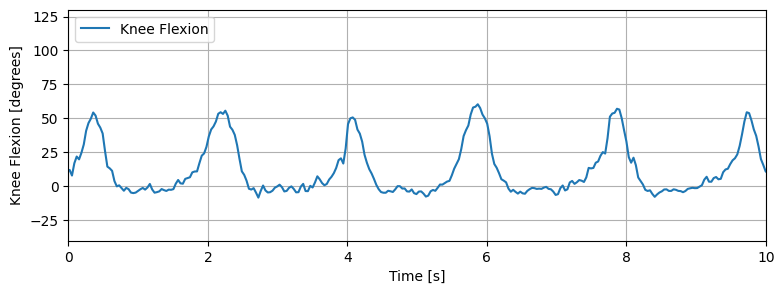

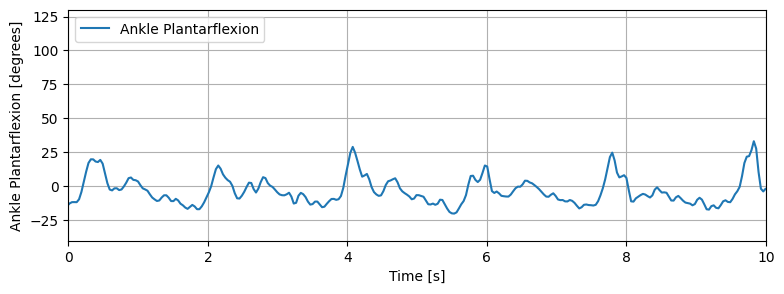

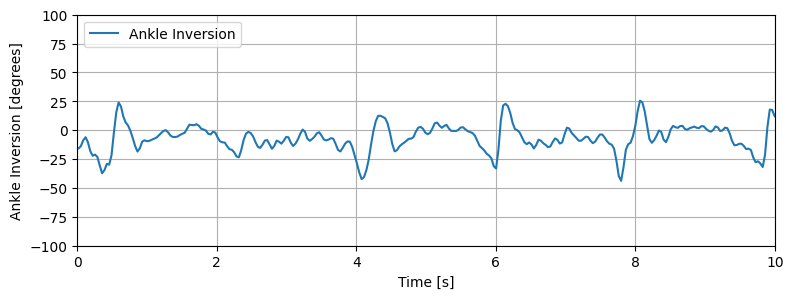

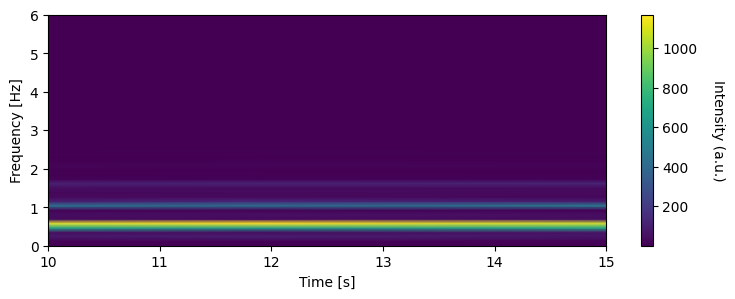

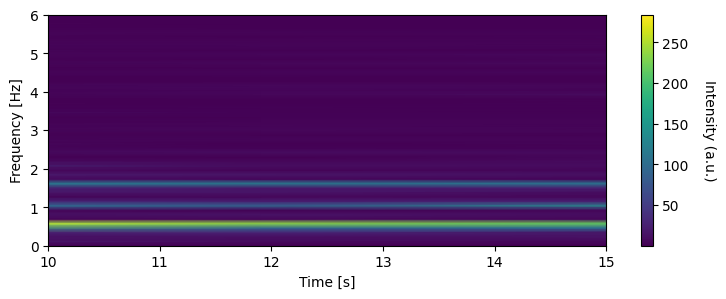

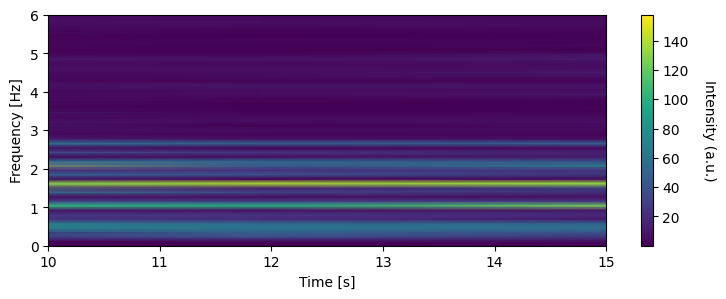

Label: 1 mph and Index: 1
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]
Label: 2.5 mph and Index: 2
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]


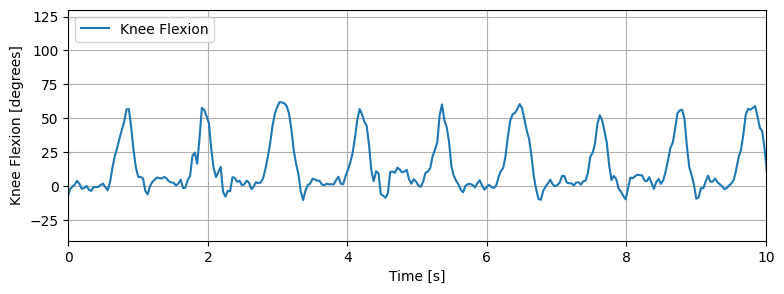

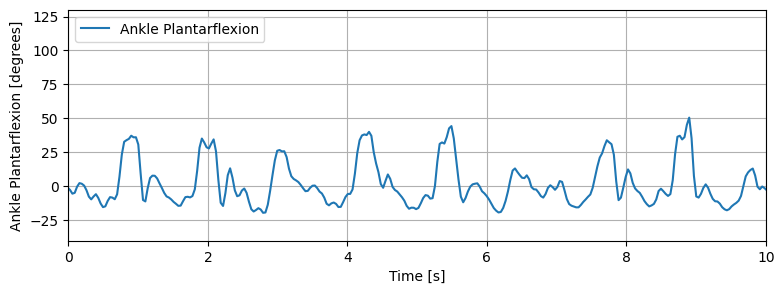

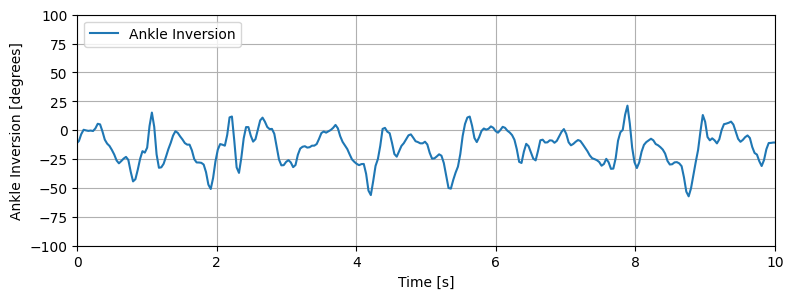

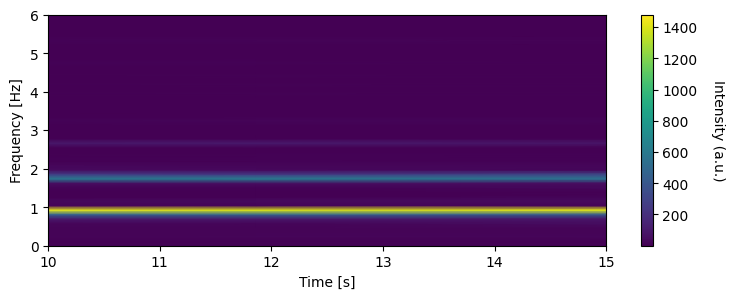

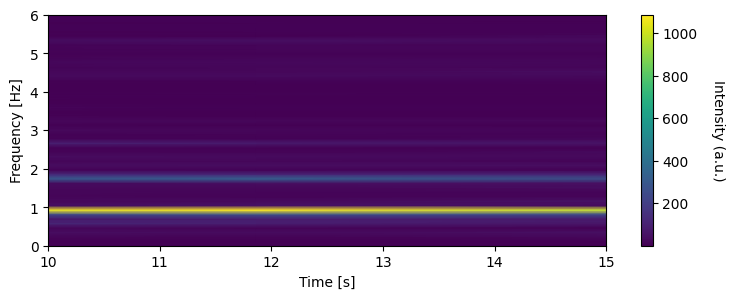

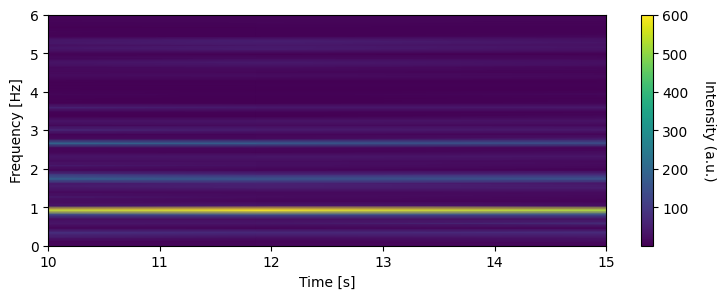

Label: 2.5 mph and Index: 3
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]
Label: 4 mph and Index: 4
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]


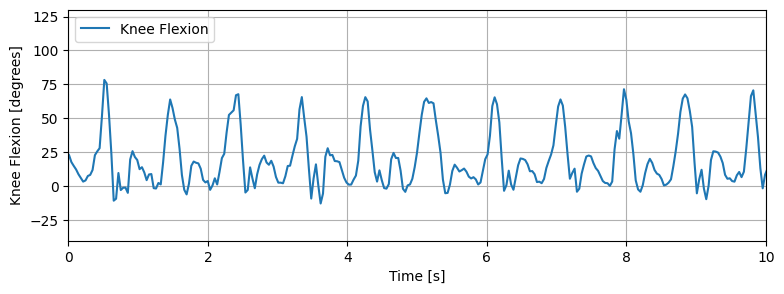

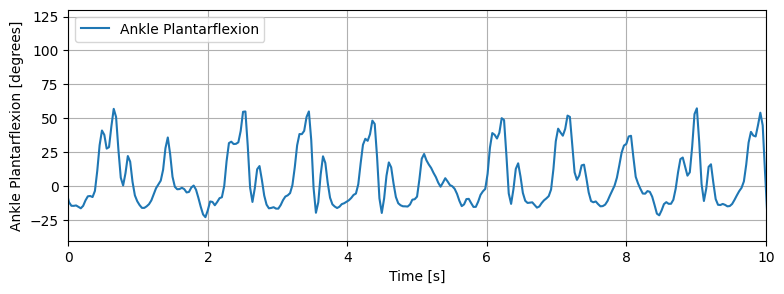

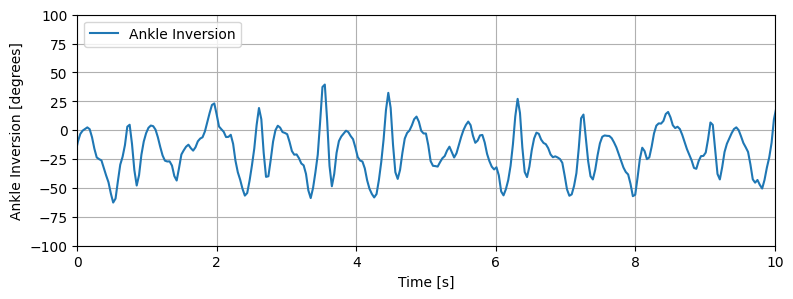

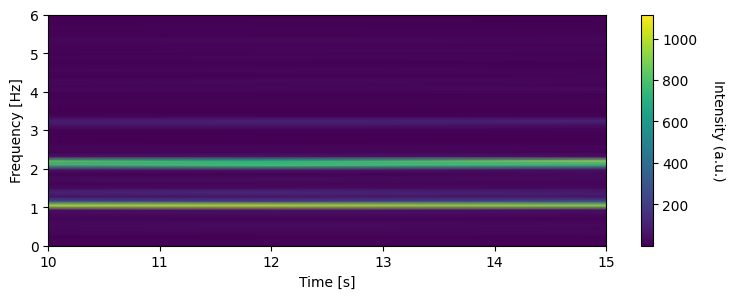

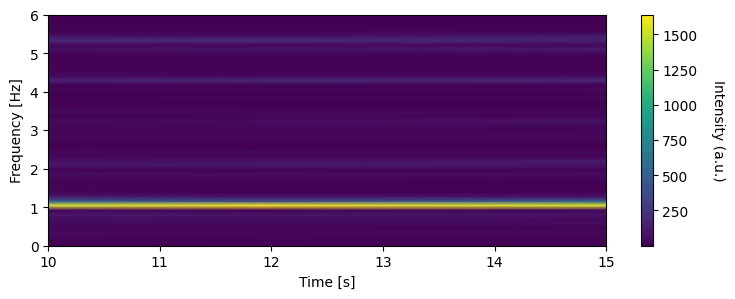

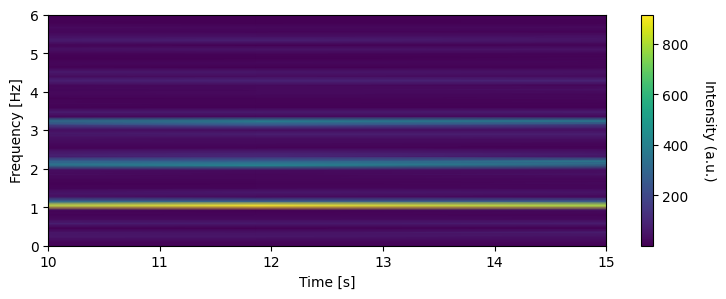

Label: 4 mph and Index: 5
foot: [ 0.3439724  -0.07707073 -0.93581146]
Initial angles between femur and tibia: [-1.79588427e-16 -7.86896455e+00 -1.06452837e-16]
Initial angles between tibia and foot: [-2.36188357  4.6061512  -3.48725086]


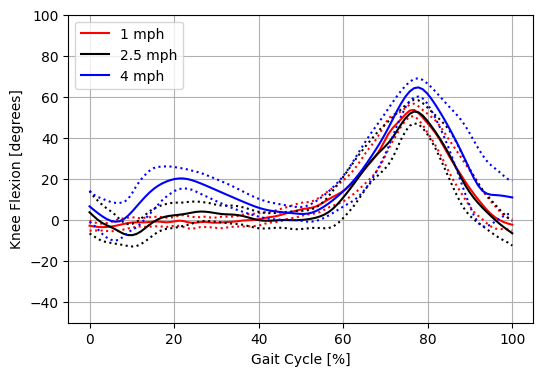

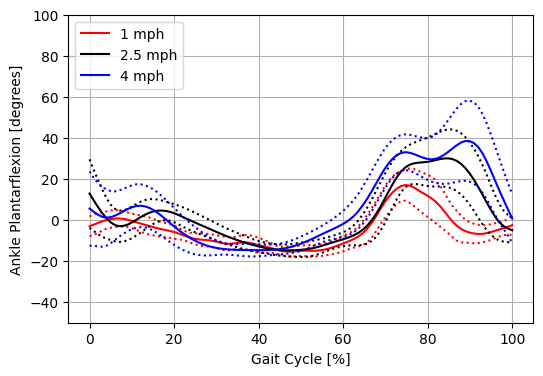

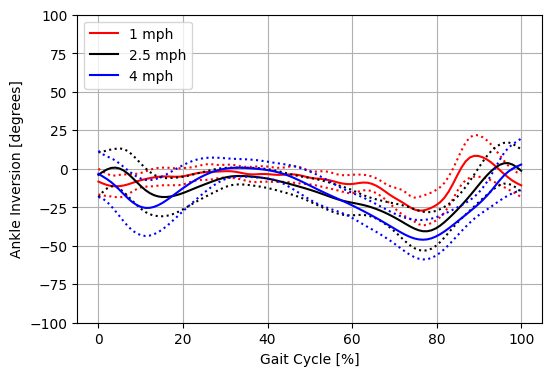

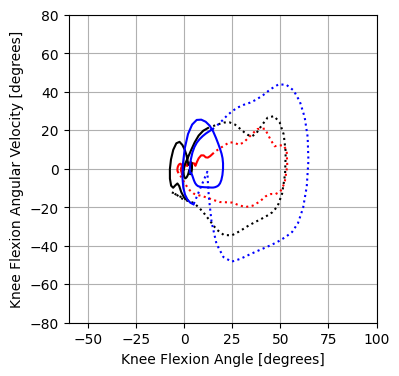

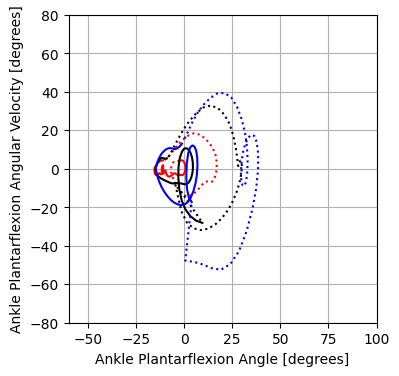

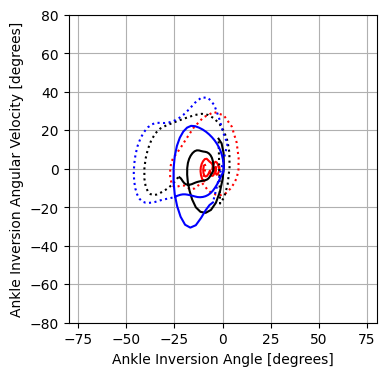

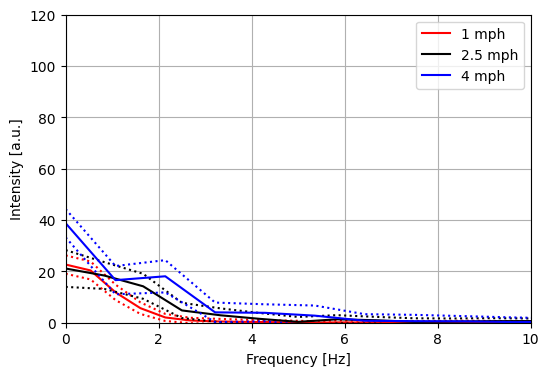

<Figure size 640x480 with 0 Axes>

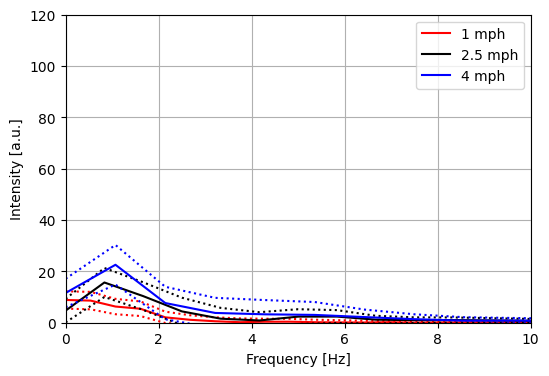

<Figure size 640x480 with 0 Axes>

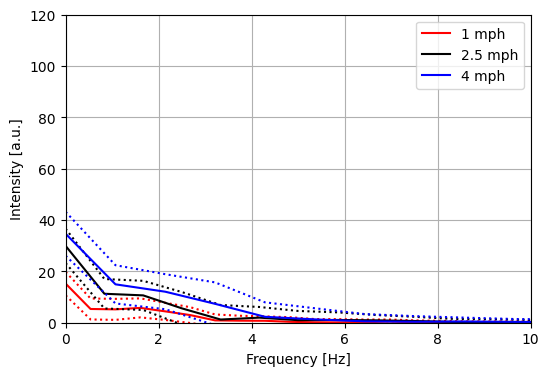

<Figure size 640x480 with 0 Axes>

In [52]:
calibration_paths = ['../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph', '../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph',
                     '../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph', '../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph',
                     '../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph', '../Mocap_3D_Trials/03_21_2024/calibration_normal_1mph']
data_paths = ['../Mocap_3D_Trials/03_21_2024/normal_1mph_test1', '../Mocap_3D_Trials/03_21_2024/normal_1mph_test2',
              '../Mocap_3D_Trials/03_21_2024/normal_25mph_test1', '../Mocap_3D_Trials/03_21_2024/normal_25mph_test2',
              '../Mocap_3D_Trials/03_21_2024/normal_4mph_test1', '../Mocap_3D_Trials/03_21_2024/normal_4mph_test2']
data_dictionary_labels = ['1 mph', '1 mph', '2.5 mph', '2.5 mph', '4 mph', '4 mph']
window_sizes_dictionary = {'1 mph' : [42, 14], '2.5 mph' : [27, 9], '4 mph' : [21, 7]}
# plot_individual_trials = [False, False, False, False, False, False]
plot_individual_trials = [True, True, True, True, True, True]
smoothing = 100
unique_dictionary_labels = ['1 mph', '2.5 mph', '4 mph']
knee_height = 40
save_label = 'messzzz'

outputs_normal = process_gait_type(calibration_paths, data_paths, data_dictionary_labels, window_sizes_dictionary, plot_individual_trials, smoothing, unique_dictionary_labels, knee_height, save_label)